<a href="https://colab.research.google.com/github/vanessavmac/syde572-intro-to-pattern-recognition/blob/main/syde572_assignment2_question3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYDE572 Assignment 2 - Question 3

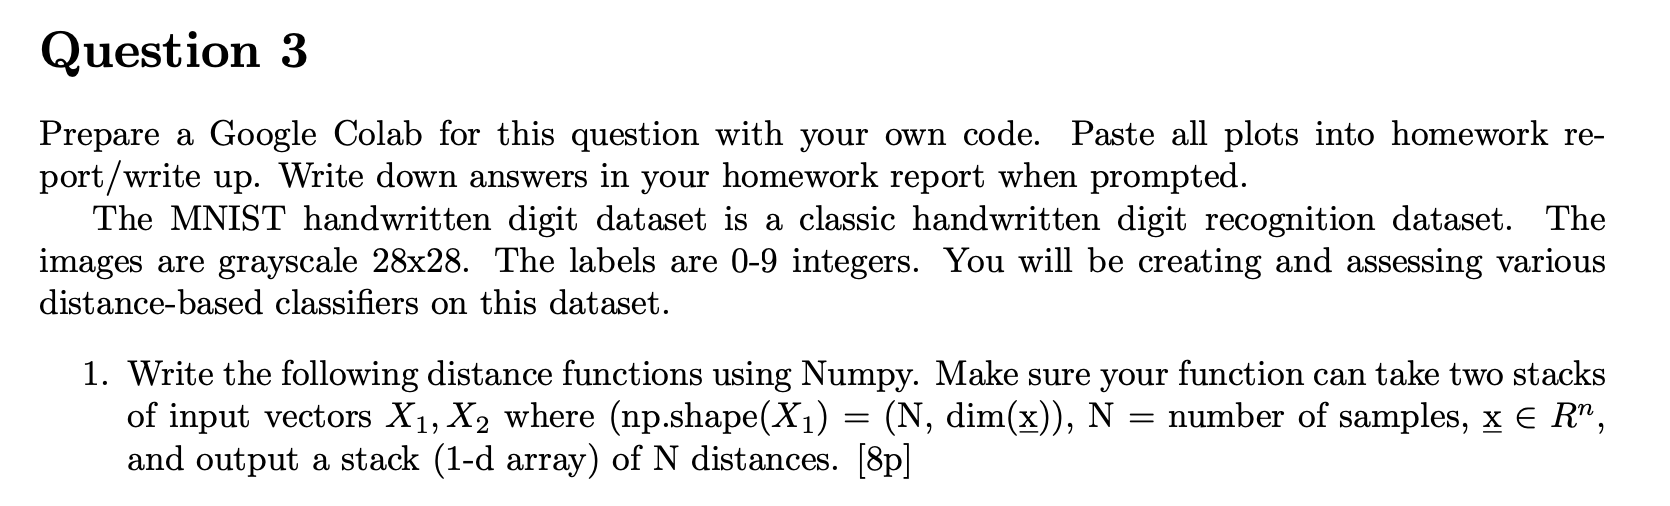

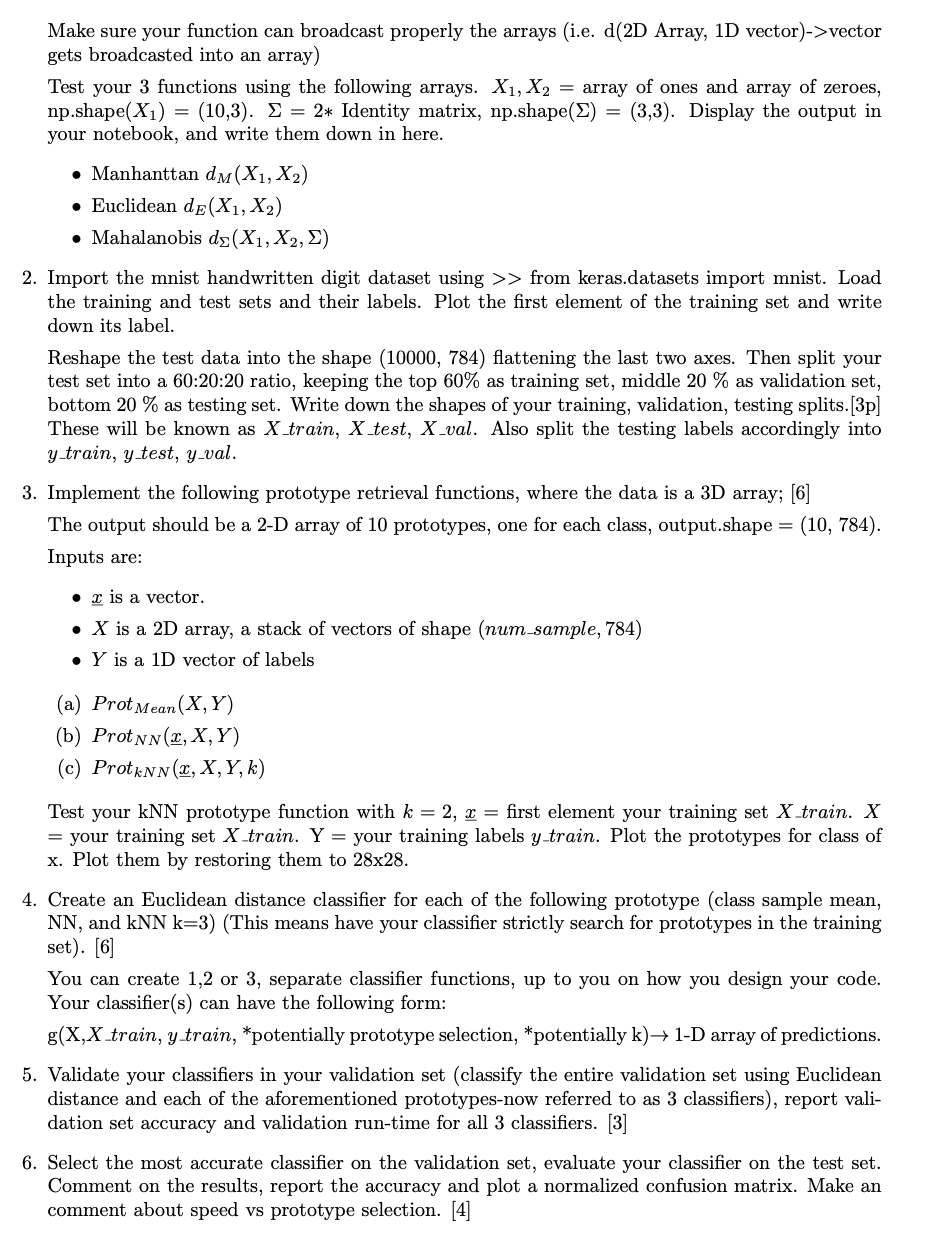

In [ ]:
import numpy as np
import pandas as pd
import math
from keras.datasets import mnist
from PIL import Image as im
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(1)


## Part 1

In [ ]:
# measures distance between X1 samples and X2
# np.shape(X1) == (num_samples, num_features)
# np.shape(x2) == (num_features, 1)
def manhattan(X1, X2):
  # broadcast to 2D array if given vector
  if np.ndim(X1) == 1:
    size = np.size(X1)
    X1 = np.reshape(X1, (1,size))
  NUM_SAMPLES = np.shape(X1)[0]
  NUM_FEATURES = np.shape(X1)[1]

  if np.ndim(X2) == 1:
    # broadcast to 2D array by replicating rows
    X2 = np.tile(X2, (NUM_SAMPLES,1))
    assert np.shape(X1) == np.shape(X2)

  distances = np.linalg.norm(np.subtract(X1,X2), ord=1, axis=1)
  assert np.shape(distances) == (NUM_SAMPLES,)
  assert distances.dtype == np.float64
  return distances

def euclidean(X1, X2):
  # broadcast to 2D array if given vector
  if np.ndim(X1) == 1:
    size = np.size(X1)
    X1 = np.reshape(X1, (1,size))
  NUM_SAMPLES = np.shape(X1)[0]
  NUM_FEATURES = np.shape(X1)[1]

  if np.ndim(X2) == 1:
    # broadcast to 2D array by replicating rows
    X2 = np.tile(X2, (NUM_SAMPLES,1))
    assert np.shape(X1) == np.shape(X2)

  distances = np.linalg.norm(np.subtract(X1,X2), ord=2, axis=1)
  assert np.shape(distances) == (NUM_SAMPLES,)
  assert distances.dtype == np.float64
  return distances

def mahalanobis(X1, X2, sigma):
  # broadcast to 2D array if given vector
  if np.ndim(X1) == 1:
    size = np.size(X1)
    X1 = np.reshape(X1, (1,size))
  NUM_SAMPLES = np.shape(X1)[0]
  NUM_FEATURES = np.shape(X1)[1]

  inv_sigma = np.linalg.inv(sigma)

  if np.ndim(X2) == 1:
    # broadcast to 2D array by replicating rows
    X2 = np.tile(X2, (NUM_SAMPLES,1))
    assert np.shape(X1) == np.shape(X2)

  distances = np.array([])
  for idx in range(NUM_SAMPLES):
    sample = X1[idx]
    norm = np.subtract(sample, X2[idx])
    squared_dist = np.matmul(np.matmul(np.transpose(norm), inv_sigma), norm)
    distance = math.sqrt(squared_dist)
    distances = np.append(distances, [distance])

  assert np.shape(distances) == (NUM_SAMPLES,)
  assert distances.dtype == np.float64
  return distances

In [ ]:
X1 = np.ones((10,3))
x2 = np.zeros(3)
sigma = 2 * np.identity(3)

dM = manhattan(X1, x2)
dE = euclidean(X1, x2)
dMaha = mahalanobis(X1, x2, sigma)

print('Test Distance Functions')
print('Manhattan: ', dM)
print('Euclidean: ', dE)
print('Mahalanobis: ', dMaha)

Test Distance Functions
Manhattan:  [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Euclidean:  [1.73205081 1.73205081 1.73205081 1.73205081 1.73205081 1.73205081
 1.73205081 1.73205081 1.73205081 1.73205081]
Mahalanobis:  [1.22474487 1.22474487 1.22474487 1.22474487 1.22474487 1.22474487
 1.22474487 1.22474487 1.22474487 1.22474487]


## Part 2

In [ ]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
assert xtrain.shape == (60000, 28, 28)
assert xtest.shape == (10000, 28, 28)
assert ytrain.shape == (60000,)
assert ytest.shape == (10000,)

# Change dataset to float for accurate training
xtest = xtest.astype(np.float64)

Label =  5


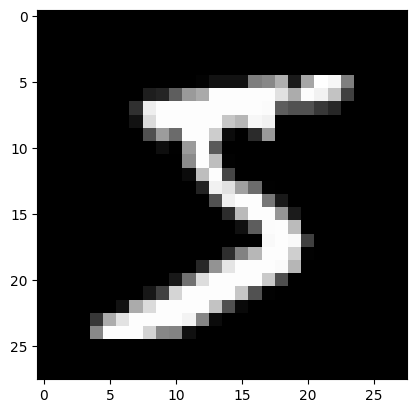

In [ ]:
plt.imshow(xtrain[0], cmap='gray')
print('Label = ', ytrain[0])

In [ ]:
# Reshape test data, flatten images
NUM_SAMPLES = 10000
IMG_LENGTH = 784

xtest_flattened = np.reshape(xtest, (NUM_SAMPLES, IMG_LENGTH))
ytest = np.reshape(ytest, (NUM_SAMPLES, 1))
assert (xtest_flattened[0,28:48] == xtest[0,0,1]).all() # sanity check

# Split test into 60:20:20
X_train = xtest_flattened[:int(NUM_SAMPLES*0.6)]
X_val = xtest_flattened[int(NUM_SAMPLES*0.6):int(NUM_SAMPLES*0.8)]
X_test = xtest_flattened[int(NUM_SAMPLES*0.8):]

y_train = ytest[:int(NUM_SAMPLES*0.6), -1]
y_val = ytest[int(NUM_SAMPLES*0.6):int(NUM_SAMPLES*0.8), -1]
y_test = ytest[int(NUM_SAMPLES*0.8):, -1]

print("Training/Test/Val Shapes")
print('X_train: ', np.shape(X_train))
print('X_val: ', np.shape(X_val))
print('X_test: ', np.shape(X_test))
print("\nTraining/Test/Val Label Shapes")
print('y_train: ', np.shape(y_train))
print('y_val: ', np.shape(y_val))
print('y_test: ', np.shape(y_test))

Training/Test/Val Shapes
X_train:  (6000, 784)
X_val:  (2000, 784)
X_test:  (2000, 784)

Training/Test/Val Label Shapes
y_train:  (6000,)
y_val:  (2000,)
y_test:  (2000,)


In [ ]:
# # Sanity Check -- check that train/test/val labels still match (try unflattening image and make sure it matches label)
# fig = plt.figure(figsize=(4, 8))
# img = np.reshape(X_test[211], (28,28))
# plt.imshow(img)
# plt.show()
# print(y_test[211])

In [ ]:
# Delete variables to avoid typos
del(xtrain)
del(ytrain)
del(xtest)
del(ytest)

## Part 3

In [ ]:
# Prototype retrieval functions
# x and Y are always 1D vectors
# X = samples, Y = labels
def mean_prot(X, Y):
  assert np.shape(X)[1] == IMG_LENGTH
  assert np.ndim(X) == 2
  assert np.ndim(Y) == 1

  output = np.array([])
  for i in range(10):
    class_samples_idx = np.argwhere(Y==i)
    class_samples = np.squeeze(X[class_samples_idx])
    prototype = np.mean(class_samples, axis=0)
    if np.size(output) == 0:
      output = np.array(prototype)
    else:
      output = np.vstack((output, prototype))

  # output is 2D array of 10 prototypes (one for each class)
  assert np.shape(output) == (10, IMG_LENGTH)
  assert output.dtype == np.float64
  return output

# x = sample, X = samples, Y = labels
def nn_prot(x, X, Y):
  assert np.shape(X)[1] == IMG_LENGTH
  assert np.ndim(X) == 2
  assert np.ndim(Y) == 1
  assert np.ndim(x) == 1

  output = np.array([])
  for i in range(10):
    class_samples_idx = np.argwhere(Y==i)
    class_samples = np.squeeze(X[class_samples_idx])
    # Calculate distance between each point and x
    distances = euclidean(class_samples, x)
    assert np.size(distances) == np.shape(class_samples)[0]
    # Find nearest neighbor
    sort_idx = np.argsort(distances)
    prototype = class_samples[sort_idx[0]]
    if np.size(output) == 0:
      output = np.array(prototype)
    else:
      output = np.vstack((output, prototype))

  # output is 2D array of 10 prototypes (one for each class)
  assert np.shape(output) == (10, IMG_LENGTH)
  assert output.dtype == np.float64
  return output

# x = sample, X = samples, Y = labels, k = # nearest neighbors
def knn_prot(x, X, Y, k):
  assert np.shape(X)[1] == IMG_LENGTH
  assert np.ndim(X) == 2
  assert np.ndim(Y) == 1
  assert np.ndim(x) == 1

  output = np.array([])
  for i in range(10):
    class_samples_idx = np.argwhere(Y==i)
    class_samples = np.squeeze(X[class_samples_idx])
    # Calculate distance between each point and x
    distances = euclidean(class_samples, x)
    assert np.size(distances) == np.shape(class_samples)[0]
    # Find k nearest neighbors
    sort_idx = np.argsort(distances)
    k_nearest_neighbors = class_samples[sort_idx[:k]]
    assert np.shape(k_nearest_neighbors)[0] == k
    prototype = np.mean(k_nearest_neighbors, axis=0)
    if np.size(output) == 0:
      output = np.array(prototype)
    else:
      output = np.vstack((output, prototype))

  # output is 2D array of 10 prototypes (one for each class)
  assert np.shape(output) == (10, IMG_LENGTH)
  assert output.dtype == np.float64
  return output

Display mean prototypes of X_train


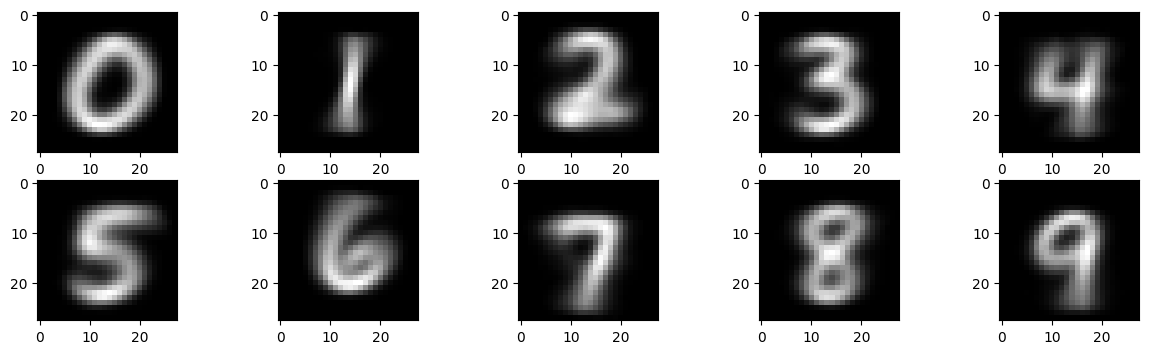

In [ ]:
print("Display mean prototypes of X_train")
mean_prots = mean_prot(X_train, y_train)

fig = plt.figure(figsize=(15, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = np.reshape(mean_prots[i-1], (28,28))
    plt.imshow(img, cmap='gray')
plt.show()

Display NN prototypes of X_train (x=first element of X_train)


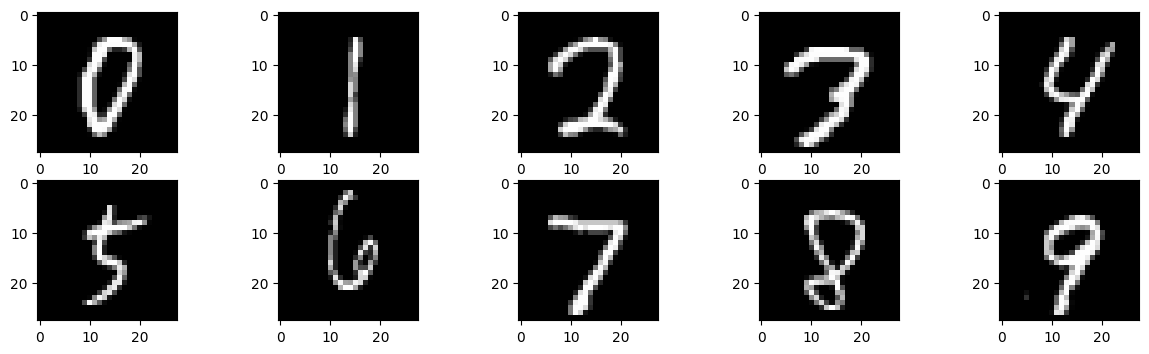

In [ ]:
print("Display NN prototypes of X_train (x=first element of X_train)")
nn_prots = nn_prot(X_train[0], X_train, y_train)

fig = plt.figure(figsize=(15, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = np.reshape(nn_prots[i-1], (28,28))
    plt.imshow(img, cmap='gray')
plt.show()

Display kNN prototypes of X_train (x=first element of X_train, k=2)


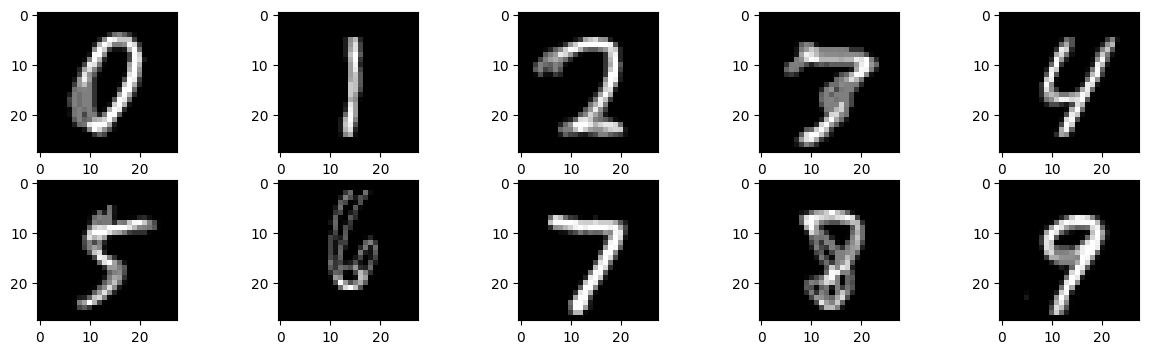

In [ ]:
print("Display kNN prototypes of X_train (x=first element of X_train, k=2)")
knn_prots = knn_prot(X_train[0], X_train, y_train, 2)

fig = plt.figure(figsize=(15, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = np.reshape(knn_prots[i-1], (28,28))
    plt.imshow(img, cmap='gray')
plt.show()

## Part 4

In [ ]:
# MED Classifier
def g_mean_euclidean(inputs, X, y):
  start = time.time()
  assert np.shape(inputs)[1] == np.shape(X)[1]

  # Just once, calculate prototypes of X_train (should have 10 prototypes)
  z_set = mean_prot(X, y)
  # Calculate distance between all inputs and all prototypes
  distances_inputs_to_z_set = np.array([])
  for z in z_set:
    dist_inputs_to_z = euclidean(inputs, z)
    assert np.shape(dist_inputs_to_z) == (np.shape(inputs)[0],)

    if np.size(distances_inputs_to_z_set) == 0:
      distances_inputs_to_z_set = np.array(dist_inputs_to_z)
    else:
      distances_inputs_to_z_set = np.vstack((distances_inputs_to_z_set, dist_inputs_to_z))

  sorted_idx = np.argsort(distances_inputs_to_z_set, axis=0)
  assert np.shape(distances_inputs_to_z_set) == np.shape(sorted_idx) == (10, np.shape(inputs)[0])

  predictions = sorted_idx[0,:]
  assert np.size(predictions) == np.shape(inputs)[0]
  assert np.ndim(predictions) == 1

  end = time.time()
  runtime = end - start
  return predictions, runtime

# nn ED Classifier
def g_nn_euclidean(inputs, X, y):
  start = time.time()
  assert np.shape(inputs)[1] == np.shape(X)[1]

  predictions = np.array([])
  # For each input, calculate 10 prototypes (RECALCUALTE PROTOTYPES FOR EACH INPUT)
  for input in inputs:
    z_set = nn_prot(input, X, y)
    # fig = plt.figure(figsize=(15, 4))
    # columns = 5
    # rows = 2
    # for i in range(1, columns*rows +1):
    #     fig.add_subplot(rows, columns, i)
    #     img = np.reshape(z_set[i-1], (28,28))
    #     plt.imshow(img)
    # plt.show()

    distances_inputs_to_z_set = np.array([])
    for z in z_set:
      dist_input_to_z = euclidean(np.reshape(input, (1,784)), z)
      assert np.size(dist_input_to_z) == 1
      distances_inputs_to_z_set = np.append(distances_inputs_to_z_set, dist_input_to_z[0])
    assert np.size(distances_inputs_to_z_set) == 10
    sorted_idx = np.argsort(distances_inputs_to_z_set)
    predictions = np.append(predictions, sorted_idx[0])

  # Classify each input based on closest prototype
  assert np.size(predictions) == np.shape(inputs)[0]
  assert np.ndim(predictions) == 1

  end = time.time()
  runtime = end - start
  return predictions, runtime

# knn ED Classifier
def g_knn_euclidean(inputs, X, y, k):
  start = time.time()
  assert np.shape(inputs)[1] == np.shape(X)[1]

  predictions = np.array([])
  # For each input, calculate 10 prototypes (RECALCUALTE PROTOTYPES FOR EACH INPUT)
  for input in inputs:
    z_set = knn_prot(input, X, y, k)
    # fig = plt.figure(figsize=(15, 4))
    # columns = 5
    # rows = 2
    # for i in range(1, columns*rows +1):
    #     fig.add_subplot(rows, columns, i)
    #     img = np.reshape(z_set[i-1], (28,28))
    #     plt.imshow(img)
    # plt.show()

    distances_inputs_to_z_set = np.array([])
    for z in z_set:
      dist_input_to_z = euclidean(np.reshape(input, (1,784)), z)
      assert np.size(dist_input_to_z) == 1
      distances_inputs_to_z_set = np.append(distances_inputs_to_z_set, dist_input_to_z[0])
    assert np.size(distances_inputs_to_z_set) == 10
    sorted_idx = np.argsort(distances_inputs_to_z_set)
    predictions = np.append(predictions, sorted_idx[0])

  # Classify each input based on closest prototype
  assert np.size(predictions) == np.shape(inputs)[0]
  assert np.ndim(predictions) == 1

  end = time.time()
  runtime = end - start
  return predictions, runtime


## Part 5

In [ ]:
# Test MED classifier on validation set
med_predictions, med_runtime = g_mean_euclidean(X_val, X_train, y_train)
med_accuracy = accuracy_score(med_predictions, y_val)
assert np.size(med_predictions) == 2000
print('MED validation set accuracy: ', '{0:.2f}'.format(med_accuracy*100), '%')
print('MED validation runtime: ', med_runtime)

# Test nn ED classifier on validation set
nn_predictions, nn_runtime = g_nn_euclidean(X_val, X_train, y_train)
nn_accuracy = accuracy_score(nn_predictions, y_val)
assert np.size(nn_predictions) == 2000
print('nn ED validation set accuracy: ', '{0:.2f}'.format(nn_accuracy*100), '%')
print('nn ED validation runtime: ', nn_runtime)

# Test knn ED classifier on validation set (k=3)
knn_predictions, knn_runtime = g_knn_euclidean(X_val, X_train, y_train, 3)
knn_accuracy = accuracy_score(knn_predictions, y_val)
assert np.size(knn_predictions) == 2000
print('knn ED validation set accuracy (k=3): ', '{0:.2f}'.format(knn_accuracy*100), '%')
print('knn ED validation runtime (k=3): ', knn_runtime)

MED validation set accuracy:  80.60 %
MED validation runtime:  0.5773816108703613
nn ED validation set accuracy:  95.25 %
nn ED validation runtime:  66.451247215271
knn ED validation set accuracy (k=3):  97.15 %
knn ED validation runtime (k=3):  61.29155421257019


Based on validation set accuracy, kNN performed the best.

In [ ]:
# Test knn ED classifier on validation set (k=1 should behave the same as nn)
knn_predictions, knn_runtime = g_knn_euclidean(X_val, X_train, y_train, 1)
knn_accuracy = accuracy_score(knn_predictions, y_val)
assert np.size(knn_predictions) == 2000
print('knn ED validation set accuracy (k=1): ', '{0:.2f}'.format(knn_accuracy*100), '%')
print('knn ED validation runtime (k=1): ', knn_runtime)

knn ED validation set accuracy (k=1):  95.25 %
knn ED validation runtime (k=1):  63.064006328582764


## Part 6

knn ED test set accuracy (k=3):  95.35 %
knn ED test runtime (k=3):  69.00456953048706


<Figure size 4000x4000 with 0 Axes>

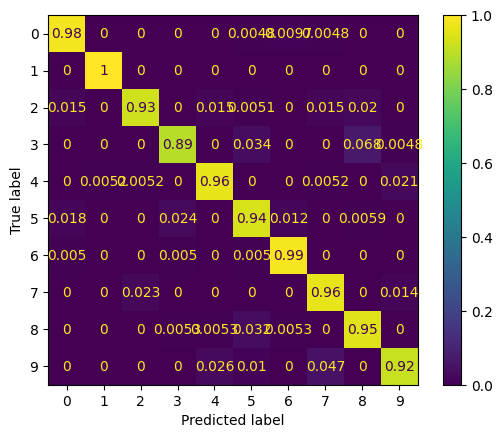

In [ ]:
# Test knn ED classifier on test set
knn_test_predictions, knn_test_runtime = g_knn_euclidean(X_test, X_train, y_train, 3)
knn_test_accuracy = accuracy_score(knn_test_predictions, y_test)
print('knn ED test set accuracy (k=3): ', '{0:.2f}'.format(knn_test_accuracy*100), '%')
print('knn ED test runtime (k=3): ', knn_test_runtime)

cm = confusion_matrix(y_test, knn_test_predictions, normalize='true')

plt.figure(figsize=(40,40))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Comments: on results and speed vs prototype selection

The knn ED classifier performs similarly on both the validation and test set (97.15% vs 95.35%) which indicates that the model is not likely overfitted and is not sensitive to noise/outliers. However, the runtime is significantly longer than the mean ED classifier, as expected, since the prototype must be recalculated for each input point. The knn has a very similar run time to the NN, which is expected since k is relatively small. Depending on implementation, larger k means longer run time since extra processing is required to calculate the k smallest distances for each point and calculate the mean. The knn ED classifier also has a slightly higher accuracy than nn ED classifier since k=3 (vs with nn, k=1) which makes the model more robust to outliers.

The mean euclidean distance classifier is significantly faster since the prototype does not have to be calculated for each prediction. However, the accuracy is significantly lower on the validation set. This most likely means that the assumed hypersphere class shape does not represent the data well.


# Extra: Run mean and nn ED classifiers on test dataset

In [ ]:
# Test MED classifier on test set
med_test_predictions, med_test_runtime = g_mean_euclidean(X_test, X_train, y_train)
med_test_accuracy = accuracy_score(med_test_predictions, y_test)
print('MED test set accuracy: ', med_test_accuracy*100, '%')
print('MED test runtime: ', med_test_runtime)

# Test nn ED classifier on test set
nn_test_predictions, nn_test_pruntime = g_nn_euclidean(X_test, X_train, y_train)
nn_test_accuracy = accuracy_score(nn_test_predictions, y_test)
print('nn ED test set accuracy: ', nn_test_accuracy*100, '%')
print('nn ED test runtime: ', nn_test_pruntime)

MED test set accuracy:  81.6 %
MED test runtime:  0.14731621742248535
nn ED test set accuracy:  95.05 %
nn ED test runtime:  62.57914638519287
